# Install dependacies and import libraries

Firstly we will need to install a few things, namely pytorch! Each time you run the notebook you'll need to reinstall.

In [1]:
!apt-get install libsndfile1 -y && pip3 install librosa http://download.pytorch.org/whl/cu80/torch-0.3.0.post4-cp36-cp36m-linux_x86_64.whl torchvision pysoundfile

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libsndfile1 is already the newest version (1.0.28-4).
0 upgraded, 0 newly installed, 0 to remove and 4 not upgraded.


In [0]:
# Url management.
import io
from six.moves.urllib.request import urlopen

# For teacher forcing.
import random

# Audio libraries.
import IPython
import librosa
import librosa.display
import soundfile as sf

# A very useful numerical package.
import numpy as np

# NumPy on steriods.
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.autograd import Variable

# Stats for outlier detection.
from scipy import stats
from sklearn import svm
from sklearn import decomposition
from sklearn.neighbors import LocalOutlierFactor

# To make nice plots.
import matplotlib.font_manager
import matplotlib.pyplot as plt

In [0]:
def to_var(x):
  if torch.cuda.is_available():
      x = x.cuda()
  return Variable(x)

# Build models

Now we build the generator and discriminator

In [0]:
class EncoderRNN(nn.Module):
  
  """The encoder takes a batch of FFT frame sequences and returns encodings.
  
  There are no embeddings as the inputs are already real values, and the
  objective is to take FFT frames sequences (batch_size, sequence_length,
  fft_size) and return the encodings (batch_size, sequence_length, hidden_size).
  """
  
  def __init__(self, 
               input_size, 
               batch_size,
               hidden_size, 
               number_layers=1, 
               dropout=0.1,
               bi_directional=True,
               rnn=nn.GRU):
    
    """The __init__ function.

    Sets up the encoder with the specified amount of layers and hidden size.
    Uses a different mask for each timestep, which has been shown to perform
    worse than if the mask was the same, for diffent layers at different
    timesteps as in https://arxiv.org/abs/1512.05287. So be wary of this! To
    entirely cancel out the dropout, just set dropout to zero.
    
    Arguments:
      input_size: Size of the input FFT frames.
      hidden_size: Size of the hidden learnable weights for the RNN.
      number_layers: How many layers the encoding RNN should have.
      dropout: Zero for no dropout, one for complete dropout.
      bi_directional: Whether or not the RNN should run in two directions.
      rnn_type: Pass a RNN module here such as nn.GRU or nn.LSTM.
    """
    
    super(EncoderRNN, self).__init__()
    
    self.input_size = input_size
    self.batch_size = batch_size
    self.hidden_size = hidden_size
    self.number_layers = number_layers
    self.dropout = dropout
    self.bi_directional = bi_directional
    self.rnn = rnn(input_size=input_size,
                   hidden_size=hidden_size,
                   num_layers=number_layers, 
                   bidirectional=bi_directional,
                   batch_first=True)
    
    
  def forward(self, x, hidden):
    """The forward propoagation function. 
    
    The 
    """
    
    x, hidden = self.rnn(x, hidden)
    
    # linearly sum bi-directional outputs if appropriate.
    if self.bi_directional:
      forward = x[:, :, :self.hidden_size]
      backward = x[:, : ,self.hidden_size:]
      x = forward + backward
    
    return x, hidden
  
  
  def init_hidden(self):
    """"""
    amount = 2 if self.bi_directional else 1
    tensor = torch.FloatTensor(self.number_layers * amount, 
                               self.batch_size, 
                               self.hidden_size)
    return to_var(tensor.fill_(0))

  
  
class Attention(nn.Module):
  
  """An attention module that can switch between different scoring methods.
  
  The general form of the attention calculation uses the target decoder hidden
  state and the encoder state.
  
  Find the scoring methods here: https://arxiv.org/abs/1508.04025. The options
  are; 'dot', a dot product between the decoder and encoder state; 'general', 
  the dot product between the decoder state and a linear transform of the
  encoder state; 'concat', a dot product between a new parameter 'v' and a 
  linear transform of the states concatenated together. Finally the result is
  normalised.
  """
  
  def __init__(self, method, batch_size, hidden_size, bias=True):
    super(Attention, self).__init__()
    
    self.method = method
    self.batch_size = batch_size
    self.hidden_size = hidden_size
    
    
    
    if self.method == 'general':
      self.attention = nn.Linear(hidden_size, hidden_size, bias=bias)
      
    elif self.method == 'concat':
      self.attention = nn.Linear(hidden_size * 2, hidden_size, bias=bias)
      self.v = nn.Parameter(torch.FloatTensor(batch_size, 1, hidden_size))
      
    
  def forward(self, hidden, encoder_outputs):
    max_length = encoder_outputs.size(1)
    
    if self.method == 'general':
      attention_energies = self.attention(encoder_outputs).transpose(2, 1)
      attention_energies = hidden.bmm(attention_energies)
    
    elif self.method == 'concat':
      # Broadcast hidden to encoder_outputs size.
      hidden *= to_var(encoder_outputs.data.new(encoder_outputs.size()).fill_(1))
      concat = torch.cat((hidden, encoder_outputs), -1)
      attention_energies = self.attention(concat)
      
      # Swap the second and first dimensions. 
      attention_energies = attention_energies.transpose(2, 1)
      attention_energies = self.v.bmm(attention_energies)
      
    else:
      # Method is 'dot'.
      encoder_outputs = encoder_outputs.transpose(2, 1)
      attention_energies = hidden.bmm(encoder_outputs)
      
    return F.softmax(attention_energies)
    
  
  
  def score(self, hidden, encoder_output):
    
    if self.method == 'dot':
      energy = hidden.dot(encoder_output)
      
    elif self.method == 'general':
      energy = self.attention(encoder_output)
      energy = hidden.dot(encoder_output)
      
    elif self.method == 'concat':
      concat = torch.cat((hidden, encoder_output), 1)
      energy = self.attention(concat)
      energy = self.v.dot(energy)
      
    return energy
      
        

class AttentionDecoderRNN(nn.Module):
  
  """Luong Attention Decoder RNN module.
  
  This decoder plugs in the Attention module ater the RNN to calculate the """
  
  def __init__(self, 
               attention_method,
               batch_size,
               hidden_size, 
               output_size, 
               number_layers=1, 
               dropout=0.1):
    
    super(AttentionDecoderRNN, self).__init__()
    
    self.attention_method = attention_method
    self.batch_size = batch_size
    self.hidden_size = hidden_size
    self.output_size = output_size
    self.number_layers = number_layers
    self.dropout = dropout
    
    self.rnn = nn.GRU(hidden_size, 
                      hidden_size, 
                      number_layers, 
                      dropout=dropout, 
                      batch_first=True)
    
    self.concat = nn.Linear(hidden_size * 2, hidden_size)
    self.output = nn.Linear(hidden_size, output_size)
    
    self.attention = Attention(attention_method, batch_size, hidden_size)
    
    
  def forward(self, input_sequence, last_hidden, encoder_outputs):
    
    # Get current hidden state from input sequence and last hidden state.
    rnn_output, hidden = self.rnn(input_sequence, last_hidden)
    
    # Calculate attention from the current RNN state and all encoder outputs.
    attention_weights = self.attention(rnn_output, encoder_outputs)
    
    # bmm = batch matrix matrix product. Apply attention to encoder outputs to
    # get the weighted average.
    context = attention_weights.bmm(encoder_outputs)
    
    # Attentional vector using the RNN hidden state and context vector
    # concatenated together (Luong eq. 5).
    concat_input = torch.cat((rnn_output, context), -1)
    concat_output = F.tanh(self.concat(concat_input))
    
    # Finally predict next frame (Luong eq. 6, without softmax).
    output = self.output(concat_output)
    
    # Return final output, hidden state, and attention weights. We can use the
    # attention weights for visualisation.
    return output, hidden, attention_weights
  
  
### WE COULD TRY A SEQ2SEQ ATTENTION MANY TO ONE DISCRIMINATOR
  
  
class DiscriminatorRNN(nn.Module):
  
  """A binary classifier for real and fake sequences in adverserial training.
  
  There are no embeddings as the inputs are already real values, and the
  objective is to take FFT frames sequences (batch_size, sequence_length,
  fft_size) and return a binary value on whether the sequence was real or not.
  """
  
  def __init__(self, 
               input_size, 
               batch_size,
               hidden_size, 
               number_layers=1, 
               dropout=0.1,
               bi_directional=True,
               rnn=nn.GRU):
    
    """The __init__ function.

    Sets up the rnn with the specified amount of layers and hidden size. Dropout
    uses a different mask for each timestep, which has been shown to perform
    worse than if the mask was the same, for different layers at different
    timesteps as in https://arxiv.org/abs/1512.05287. So be wary of this! To
    entirely cancel out the dropout, just set dropout to zero.
    
    Arguments:
      input_size: Size of the input FFT frames.
      hidden_size: Size of the hidden learnable weights for the RNN.
      number_layers: How many layers the encoding RNN should have.
      dropout: Zero for no dropout, one for complete dropout.
      bi_directional: Whether or not the RNN should run in two directions.
      rnn_type: Pass a RNN module here such as nn.GRU or nn.LSTM.
    """
    
    super(DiscriminatorRNN, self).__init__()
    
    self.input_size = input_size
    self.batch_size = batch_size
    self.hidden_size = hidden_size
    self.number_layers = number_layers
    self.dropout = dropout
    self.bi_directional = bi_directional
    self.rnn = rnn(input_size=input_size,
                   hidden_size=hidden_size,
                   num_layers=number_layers, 
                   bidirectional=bi_directional,
                   batch_first=True)
    self.dense = nn.Linear(hidden_size, 1)
    
    
  def forward(self, x, hidden):
    """The forward propoagation function. 
    
    The 
    """
    
    x, hidden = self.rnn(x, hidden)
    
    # linearly sum bi-directional outputs if appropriate.
    if self.bi_directional:
      forward  = x[:, :, :self.hidden_size]
      backward = x[:, :, self.hidden_size:]
      x = forward + backward
    
    x = self.dense(x[:, -1, :])
    x = x.mean(0)
    x = x.view(1)
    return x, hidden

  
  def init_hidden(self):
    """"""
    amount = 2 if self.bi_directional else 1
    tensor = torch.FloatTensor(self.number_layers * amount, 
                               self.batch_size, 
                               self.hidden_size)
    return to_var(tensor.fill_(0))

# Test the encoder and decoder

In [0]:
if False:
  test_hidden_size     = 32
  test_input_size      = 32
  test_number_layers   = 3
  test_batch_size      = 16
  test_sequence_length = 7

  encoder_test = EncoderRNN(input_size=test_input_size,
                            batch_size=test_batch_size,
                            hidden_size=test_hidden_size,
                            number_layers=test_number_layers)
  
  decoder_test = AttentionDecoderRNN(attention_method='general',
                                     batch_size=test_batch_size,
                                     hidden_size=test_hidden_size,
                                     output_size=test_input_size,
                                     number_layers=test_number_layers)

  if torch.cuda.is_available():
    encoder_test.cuda()
    decoder_test.cuda()

  test_input_batches = to_var(torch.zeros(test_batch_size,
                                          test_sequence_length, 
                                          test_input_size))
  test_target_batches = to_var(torch.zeros(test_batch_size,
                                           test_sequence_length, 
                                           test_input_size))

  test_encoder_hidden = encoder_test.init_hidden()
  test_encoder_outputs, test_encoder_hidden = encoder_test(test_input_batches, 
                                                           test_encoder_hidden)

  # (batch_size, sequence_length, hidden_size)
  print('encoder outputs size      {}'.format(tuple(test_encoder_outputs.size())))

  # (number_layers * num_directions, sequence_length, hidden_size)
  print('encoder hidden state size {}'.format(tuple(test_encoder_hidden.size())))

  test_decoder_input = to_var(torch.zeros(test_batch_size, 
                                          test_sequence_length, 
                                          test_hidden_size))
  test_decoder_hidden = test_encoder_hidden[:decoder_test.number_layers]
 

  test_decoder_output, test_decoder_hidden, test_decoder_attention = \
    decoder_test(test_decoder_input, test_decoder_hidden, test_encoder_outputs)

  test_criterion = nn.MSELoss()
  test_loss = test_criterion(test_decoder_output, test_target_batches)
  print(test_loss.data[0])

# Utilites

You can look for music urls [here](https://www.jewelbeat.com/free/free-background-music.htm)

In [0]:
class AudioDataset():
  """A class to convert audio found at an url to magnitude frames."""
  
  def __init__(self, url, fft_size, hop_length):
    self.fft_size = fft_size
    self.feature_size = (fft_size // 2) + 1
    self.hop_length = hop_length
    self.data, self.sample_rate = sf.read(io.BytesIO(urlopen(url).read()))
    self.data = np.mean(self.data, axis=1)[:self.sample_rate * 20]
    self.stfts = librosa.stft(self.data, n_fft=fft_size, hop_length=hop_length)
    self.magnitudes, _ = librosa.magphase(self.stfts.T)
  
  
  def get_next_batch(self, amount_epochs, batch_size, sequence_length):
    
    self.dataset_size = len(self.magnitudes) - sequence_length * 2 - 1
    
    self.x = np.zeros((self.dataset_size, sequence_length, self.feature_size), 
                       dtype=np.float32)
    self.y = np.zeros((self.dataset_size, sequence_length, self.feature_size), 
                       dtype=np.float32)
    
    for i, x_start in enumerate(range(0, self.dataset_size)):
      y_start = x_end = x_start + sequence_length
      y_end = y_start + sequence_length

      self.x[i] = self.magnitudes[x_start:x_end]
      self.y[i] = self.magnitudes[y_start:y_end]
    
    for epoch in range(amount_epochs):
      
      permuation = np.random.permutation(len(self.x))
      x, y = self.x[permuation], self.y[permuation]

      for start in range(0, len(x) - batch_size, batch_size):
        end = start + batch_size
        

        batch_x = torch.from_numpy(x[start:end])
        batch_y = torch.from_numpy(y[start:end])

        yield to_var(batch_x), to_var(batch_y), epoch 
        
        
        
def griffin_lim(spectrogram, n_iter=100, window='hann', n_fft=2048, hop_length=-1):
  if hop_length == -1:
    hop_length = n_fft // 4

  angles = np.exp(2j * np.pi * np.random.rand(*spectrogram.shape))

  for i in range(n_iter):
    full = np.abs(spectrogram).astype(np.complex) * angles
    inverse = librosa.istft(full, hop_length = hop_length, window = window)
    rebuilt = librosa.stft(inverse, n_fft = n_fft, hop_length = hop_length, window = window)
    angles = np.exp(1j * np.angle(rebuilt))

  full = np.abs(spectrogram).astype(np.complex) * angles
  inverse = librosa.istft(full, hop_length = hop_length, window = window)

  return inverse
    
  
  
def outlier_detection(data, 
                      contamination_fraction=0.25, 
                      amount_neighbours=35, 
                      figure_width=8,
                      append_covariance=False,
                      inline=False):
  
  # Get rank-2 data points.
  number_data_points = len(data)
  data = np.array(data).reshape((number_data_points, -1))

  # perform dimensionality reduction if necessary for visualisation.
  if data.shape[1] > 2:
    pca = decomposition.PCA(n_components=2)
    pca.fit(data)
    data = pca.transform(data)
    
  # Setup.
  xx, yy = np.meshgrid(np.linspace(data.min(), data.max(), 100), 
                       np.linspace(data.min(), data.max(), 100))
    
  # Instanciate outlier detection methods and find anomolies & descision bounds.
  lof = LocalOutlierFactor(n_neighbors=amount_neighbours,
                           contamination=contamination_fraction)
  lof_predictions = lof.fit_predict(data)
  lof_scores_pred = lof.negative_outlier_factor_
  lof_threshold = stats.scoreatpercentile(lof_scores_pred, 
                                          100 * contamination_fraction)
  lof_z = lof._decision_function(np.c_[xx.ravel(), yy.ravel()])
  
  # Plot everything.
  plot_data = [
      ('Local Outlier Factor', lof_z, lof_threshold, lof_predictions)
  ]
  
  # Add robust covarince method. Need fix decision boundary!
  if append_covariance:
    env = EllipticEnvelope(contamination=contamination_fraction)
    env.fit(data)
    env_predictions = env.decision_function(data)
    env_scores_pred = env.predict(data)
    env_threshold = stats.scoreatpercentile(env_scores_pred,
                                            100 * contamination_fraction)
    env_z = env.decision_function(np.c_[xx.ravel(), yy.ravel()])
    cova_data = ('Robust Covariance', env_z, env_threshold, env_scores_pred)
    plot_data.append(cova_data)
    
  fig = plt.figure(figsize=(figure_width, figure_width * len(plot_data)))
  plot_number = 1
  for title, z, threshold, predictions in plot_data:
    z = z.reshape(xx.shape)
    sub_plot = fig.add_subplot(len(plot_data), 1, plot_number)
    sub_plot.contourf(xx, yy, z, levels=np.linspace(z.min(), threshold, 7), cmap=plt.cm.Blues_r)
    sub_plot.contour(xx, yy, z, levels=[threshold], linewidths=2, colors='red')
    sub_plot.contourf(xx, yy, z, levels=[threshold, z.max()], colors='orange')

    inliers = data[np.where(predictions == 1)]
    outliers = data[np.where(predictions == -1)]
    sub_plot.scatter(inliers[:,0], inliers[:,1], c='white', s=20, edgecolor='k')
    sub_plot.scatter(outliers[:,0], outliers[:,1], c='black', s=20, edgecolor='k')

    sub_plot.axis('tight')
    sub_plot.set_xlabel(title)
    sub_plot.set_xlim((data.min(), data.max()))
    sub_plot.set_ylim((data.min(), data.max()))
    
    plot_number += 1
  
  # Convert to NumPy array and return!
  fig.subplots_adjust(0.04, 0.1, 0.96, 0.94, 0.1, 0.26)
  fig.suptitle("Outlier detection")
  
  if not inline:
    plt.close()
  else:
    fig.savefig('outlier_detection.png', dpi=fig.dpi)
  
  return fig, np.where(lof_predictions == -1)[0]



def plot_audio(data):
  plt.figure()
  stft = librosa.amplitude_to_db(librosa.stft(data), ref=np.max)
  librosa.display.specshow(stft, y_axis='log')
  plt.show()
  

# Train and inference functions

In [0]:
def train(encoder, 
          decoder, 
          discriminator,
          encoder_optimiser,
          decoder_optimiser, 
          discriminator_optimiser,
          discriminator_iterations,
          get_discriminator_batch,
          input_batch, 
          target_batch,
          criterion,
          clip_threshold,
          one,
          minus_one):
    
  batch_size, sequence_length, fft_size = tuple(input_batch.size())
 
  #==================== Generate new sequence predictions. ====================#
  
  # Run the input batch of fft sequences through the encoder.
  encoder_hidden = encoder.init_hidden()
  encoder_outputs, encoder_hidden = encoder(input_batch, encoder_hidden)
  
  # Prepare the input and output variables.
  decoder_input = input_batch
  decoder_hidden = encoder_hidden[:decoder.number_layers]
  
  decoder_output, decoder_hidden, decoder_attention = \
    decoder(decoder_input, decoder_hidden, encoder_outputs)
  
  #========================= Train the discriminator. =========================#
  
  # Disable generator and enable discriminator backprop.
  for parameter in encoder.parameters():
    parameter.requires_grad = False
  for parameter in decoder.parameters():
    parameter.requires_grad = False
  for parameter in discriminator.parameters():
    parameter.requires_grad = True
    
  # Discriminator is trained to optimality.
  for _ in range(discriminator_iterations):
    
    discriminator_optimiser.zero_grad() 
    x, y, _ = next(get_discriminator_batch)
    
    # Train with real.
    discriminator_hidden = discriminator.init_hidden()
    real_inputs = torch.cat((x, y), 1)
    discriminator_outputs_real, _ = discriminator(real_inputs, 
                                                  discriminator_hidden)
    discriminator_outputs_real.backward(one)

    # Run the input batch of fft sequences through the encoder.
    encoder_hidden = encoder.init_hidden()
    encoder_outputs, encoder_hidden = encoder(x, encoder_hidden)

    # Prepare the input and output variables.
    decoder_input = x
    decoder_hidden = encoder_hidden[:decoder.number_layers]

    decoder_output, decoder_hidden, decoder_attention = \
      decoder(decoder_input, decoder_hidden, encoder_outputs)
    
    # Train with fake.
    discriminator_hidden = discriminator.init_hidden()
    fake_inputs = torch.cat((x, decoder_output), 1)
    discriminator_outputs_fake, _ = discriminator(fake_inputs, 
                                                  discriminator_hidden)
    discriminator_outputs_fake.backward(minus_one)
    
    # Clip the gradient norms and step optimiser.
    torch.nn.utils.clip_grad_norm(discriminator.parameters(), clip_threshold)
    discriminator_optimiser.step()
    
    # Clamp parameters to a cube.
    for parameter in discriminator.parameters():
      parameter.data.clamp_(-0.01, 0.01)
  
  #=========================== Train the generator. ===========================#

  # Enable generator and disable discriminator backprop.
  for parameter in encoder.parameters():
    parameter.requires_grad = True
  for parameter in decoder.parameters():
    parameter.requires_grad = True
  for parameter in discriminator.parameters():
    parameter.requires_grad = False
    
  # Zero the gradients of both generator optimisers.
  encoder_optimiser.zero_grad()
  decoder_optimiser.zero_grad()
  
  # How does the discriminator rate the generator? Run the input batch of fft 
  # sequences through the encoder.
  encoder_hidden = encoder.init_hidden()
  encoder_outputs, encoder_hidden = encoder(input_batch, encoder_hidden)

  # Prepare the input and output variables.
  decoder_input = input_batch
  decoder_hidden = encoder_hidden[:decoder.number_layers]

  decoder_output, decoder_hidden, decoder_attention = \
    decoder(decoder_input, decoder_hidden, encoder_outputs)
    
  # How close were we to the targets? (MSE or L1 distance etc)
  distance_loss = criterion(decoder_output, target_batch) 
  distance_loss.backward(retain_graph=True)

  # Train with fake.
  discriminator_hidden = discriminator.init_hidden()
  fake_inputs = torch.cat((input_batch, decoder_output), 1)
  discriminator_outputs_fake, _ = discriminator(fake_inputs, 
                                                discriminator_hidden)
  discriminator_outputs_fake.backward(one)
  
  # Clip the gradient norms.
  torch.nn.utils.clip_grad_norm(encoder.parameters(), clip_threshold)
  torch.nn.utils.clip_grad_norm(decoder.parameters(), clip_threshold)
  
  # Update parameters with optimisers.
  encoder_optimiser.step()
  decoder_optimiser.step()
  
  #========================= Return loss and outputs. =========================#
  
  # Average discriminator outputs with respect to objectives.
  mean_real_prediction = discriminator_outputs_real.data.mean()
  mean_fake_prediction = discriminator_outputs_fake.data.mean()
  
  return distance_loss.data[0], mean_real_prediction, mean_fake_prediction

In [0]:
def run(encoder, 
        decoder, 
        start_sequences,
        amount_frames):
  
  encoder.train(False)
  decoder.train(False)
  
  # Get random sequence from dataset object. 
  batch_size, sequence_length, fft_size = start_sequences.size()
  model_input = start_sequences.view(batch_size, sequence_length, fft_size)
  
  frames = np.zeros((amount_frames, batch_size, sequence_length, fft_size))
  
  # Repeatedly sample the RNN and get the output.
  for i in range(amount_frames):

    encoder_hidden = encoder.init_hidden()
    encoder_outputs, encoder_hidden = encoder(model_input, encoder_hidden)
    
    decoder_input = model_input
    decoder_hidden = encoder_hidden[:decoder.number_layers]
    
    decoder_output, decoder_hidden, _ = \
      decoder(decoder_input, decoder_hidden, encoder_outputs)

    model_input = decoder_output    
    frames[i] = Variable(decoder_output.data).cpu().data.numpy()
    
  encoder.train(True)
  decoder.train(True)
    
  return frames.reshape((batch_size, -1, fft_size))
  

# Hyper parameters

/usr/local/lib/python3.6/dist-packages/librosa/display.py:656: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  if np.issubdtype(data.dtype, np.complex):


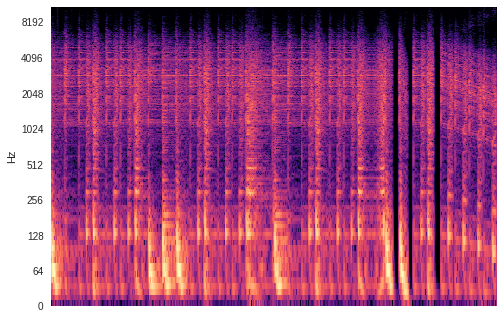

In [9]:
# Hyper parameters.
seed                   = 42
attention_method       = 'general'
fft_size               = 1024
number_layers          = 2
dropout                = 0.0
sequence_length        = 100 # was 50, 150
clip_threshold         = 5.0
criterion              = nn.MSELoss() 
learning_rate          = 0.00005
decoder_learning_ratio = 5.0
batch_size             = 2 # was 64
number_epochs          = 100
evaluate_every_epoch   = 5
lambda_a               = 10.0
beta_1                 = 0.5
use_adam               = False

feature_size = input_size = hidden_size = (fft_size // 2) + 1
hop_length = fft_size // 4

# url = 'http://www.jewelbeat.com/free/free-music/JewelBeat%20-%20Haunted%20Revenge.wav'
url = 'http://doc.gold.ac.uk/~lfedd001/original_c.wav'

# Construct RNNs.
encoder = EncoderRNN(input_size=feature_size,
                     batch_size=batch_size,
                     hidden_size=feature_size,
                     number_layers=number_layers,
                     dropout=dropout)

decoder = AttentionDecoderRNN(attention_method,
                              batch_size=batch_size,
                              hidden_size=hidden_size,
                              output_size=feature_size,
                              number_layers=number_layers,
                              dropout=dropout)

discriminator = DiscriminatorRNN(input_size=feature_size,
                                 batch_size=batch_size,
                                 hidden_size=feature_size,
                                 number_layers=number_layers,
                                 dropout=dropout)

one = torch.FloatTensor([1])
minus_one = one * -1

# Enable GPU tensors provided GPUs actually exist!
if torch.cuda.is_available():
  encoder.cuda()
  decoder.cuda()
  criterion.cuda()
  discriminator.cuda()
  torch.cuda.manual_seed(seed)
  one = one.cuda()
  minus_one = minus_one.cuda()
else:
  torch.manual_seed(seed)
  
# Construct the optimisers.
decoder_learning_rate = learning_rate * decoder_learning_ratio
if use_adam:
  encoder_optimiser = torch.optim.Adam(encoder.parameters(), 
                                       lr=learning_rate, 
                                       betas=(beta_1, 0.999))
  decoder_optimiser = torch.optim.Adam(decoder.parameters(), 
                                       lr=decoder_learning_rate, 
                                       betas=(beta_1, 0.999))
  discriminator_optimiser = torch.optim.Adam(discriminator.parameters(),
                                             lr=learning_rate,
                                             betas=(beta_1, 0.999))
else:
  encoder_optimiser = torch.optim.RMSprop(encoder.parameters(), 
                                          lr=learning_rate)
  decoder_optimiser = torch.optim.RMSprop(decoder.parameters(), 
                                          lr=decoder_learning_rate)
  discriminator_optimiser = torch.optim.RMSprop(discriminator.parameters(), 
                                                lr=learning_rate)
  
dataset = AudioDataset(url, fft_size, hop_length)
discriminator_dataset = AudioDataset(url, fft_size, hop_length)

# Plot and listen to the audio.
plot_audio(dataset.data) 
IPython.display.Audio(dataset.data, rate=dataset.sample_rate)

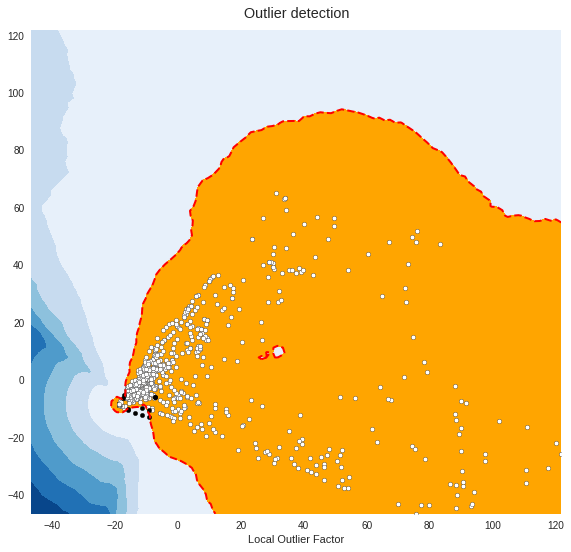

In [10]:
_ = outlier_detection(dataset.magnitudes, contamination_fraction=0.01, inline=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:132: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/librosa/util/utils.py:1725: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(x.dtype, float) or np.issubdtype(x.dtype, complex):
/usr/local/lib/python3.6/dist-packages/librosa/display.py:656: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  if np.issubdtype(data.dtype, np.complex):


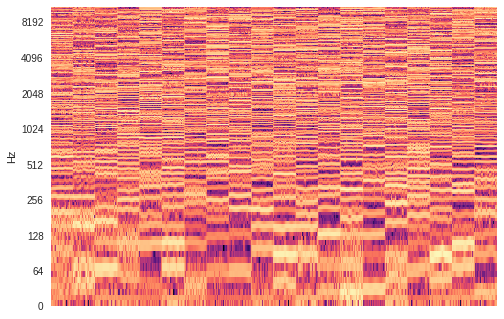

epoch 0/100, loss 3.4322800636291504, disc real -10.016759872436523, disc fake 10.028478622436523
epoch 0/100, loss 4.5621657371521, disc real -10.093940734863281, disc fake 9.800898551940918
epoch 0/100, loss 1.599839448928833, disc real -10.10321044921875, disc fake 5.160106658935547
epoch 0/100, loss 1.7724058628082275, disc real -9.650341033935547, disc fake 4.168302059173584
epoch 0/100, loss 2.9893174171447754, disc real -9.836737632751465, disc fake -0.09832681715488434
epoch 0/100, loss 1.3326352834701538, disc real -9.751378059387207, disc fake -1.696892261505127
epoch 0/100, loss 1.4728829860687256, disc real -9.65865707397461, disc fake 0.09261832386255264
epoch 0/100, loss 1.1362310647964478, disc real -9.884218215942383, disc fake 1.1807714700698853
epoch 0/100, loss 3.902183771133423, disc real -9.994945526123047, disc fake 4.189185619354248
epoch 0/100, loss 1.2944458723068237, disc real -9.923389434814453, disc fake -9.980764389038086
epoch 0/100, loss 1.911834359169006

epoch 0/100, loss 3.7177939414978027, disc real -10.171412467956543, disc fake 6.941688537597656
epoch 0/100, loss 1.9958348274230957, disc real -10.152751922607422, disc fake 7.4307708740234375
epoch 0/100, loss 1.95791494846344, disc real -10.095403671264648, disc fake 7.14473295211792
epoch 0/100, loss 2.4975459575653076, disc real -9.500484466552734, disc fake 7.133672714233398
epoch 0/100, loss 2.0733683109283447, disc real -10.189903259277344, disc fake 8.384102821350098
epoch 0/100, loss 4.286949157714844, disc real -9.83726692199707, disc fake 8.056131362915039
epoch 0/100, loss 4.497107982635498, disc real -9.990289688110352, disc fake 7.020273208618164
epoch 0/100, loss 4.248190402984619, disc real -10.011300086975098, disc fake 8.072786331176758
epoch 0/100, loss 2.779395818710327, disc real -10.151406288146973, disc fake 7.596811771392822
epoch 0/100, loss 3.978543758392334, disc real -10.108243942260742, disc fake 5.583901405334473
epoch 0/100, loss 4.20370626449585, disc 

epoch 0/100, loss 1.8454203605651855, disc real -9.941999435424805, disc fake 7.452668190002441
epoch 0/100, loss 7.153643608093262, disc real -9.925745010375977, disc fake 7.236209392547607
epoch 0/100, loss 3.1068520545959473, disc real -10.033946990966797, disc fake 7.288719654083252
epoch 0/100, loss 4.693578243255615, disc real -9.533000946044922, disc fake 8.115127563476562
epoch 0/100, loss 6.329444408416748, disc real -9.938560485839844, disc fake 8.034740447998047
epoch 0/100, loss 3.97869873046875, disc real -9.797073364257812, disc fake 8.380428314208984
epoch 0/100, loss 1.8577847480773926, disc real -10.209586143493652, disc fake 8.201669692993164
epoch 0/100, loss 2.706596612930298, disc real -9.899076461791992, disc fake 8.226156234741211
epoch 0/100, loss 1.7762423753738403, disc real -9.903441429138184, disc fake 8.244863510131836
epoch 0/100, loss 3.6521496772766113, disc real -10.112942695617676, disc fake 8.279417991638184
epoch 0/100, loss 2.676008462905884, disc r

epoch 0/100, loss 2.5580952167510986, disc real -10.213385581970215, disc fake 8.844589233398438
epoch 0/100, loss 2.1862151622772217, disc real -10.178593635559082, disc fake 9.038507461547852
epoch 0/100, loss 1.7574856281280518, disc real -10.172293663024902, disc fake 9.036510467529297
epoch 0/100, loss 2.1298906803131104, disc real -10.056514739990234, disc fake 9.222746849060059
epoch 0/100, loss 3.761138916015625, disc real -10.165397644042969, disc fake 9.061297416687012
epoch 0/100, loss 5.4381937980651855, disc real -9.9120512008667, disc fake 9.167356491088867
epoch 0/100, loss 3.126288414001465, disc real -9.828983306884766, disc fake 9.255073547363281
epoch 0/100, loss 1.9921886920928955, disc real -4.890213489532471, disc fake 9.408255577087402
epoch 0/100, loss 2.367366313934326, disc real -9.843490600585938, disc fake 9.389238357543945
epoch 0/100, loss 4.110744476318359, disc real -9.894466400146484, disc fake 9.498957633972168
epoch 0/100, loss 4.23734188079834, disc 

epoch 0/100, loss 1.9088584184646606, disc real -9.697271347045898, disc fake -10.1729736328125
epoch 0/100, loss 1.258872151374817, disc real -9.753242492675781, disc fake -10.172480583190918
epoch 0/100, loss 2.0192482471466064, disc real -10.079423904418945, disc fake -10.168392181396484
epoch 0/100, loss 0.9534951448440552, disc real -10.173429489135742, disc fake -10.170021057128906
epoch 0/100, loss 6.187358856201172, disc real -10.12954330444336, disc fake -10.168643951416016
epoch 0/100, loss 2.833890438079834, disc real -10.171348571777344, disc fake -10.163249969482422
epoch 0/100, loss 2.9542808532714844, disc real -9.936144828796387, disc fake -10.161571502685547
epoch 0/100, loss 3.530120849609375, disc real -10.152862548828125, disc fake -10.160791397094727
epoch 0/100, loss 3.62381649017334, disc real -10.002523422241211, disc fake -10.151697158813477
epoch 0/100, loss 1.0592379570007324, disc real -9.309324264526367, disc fake -10.147024154663086
epoch 0/100, loss 3.978

epoch 0/100, loss 1.9202516078948975, disc real -9.418680191040039, disc fake -10.053374290466309
epoch 0/100, loss 1.3670248985290527, disc real -9.574292182922363, disc fake -10.050445556640625
epoch 0/100, loss 3.4025442600250244, disc real -10.045888900756836, disc fake -10.049243927001953
epoch 0/100, loss 3.0936317443847656, disc real -10.034683227539062, disc fake -10.04582405090332
epoch 0/100, loss 2.7059388160705566, disc real -10.024869918823242, disc fake -10.039468765258789
epoch 0/100, loss 1.0118627548217773, disc real -9.99043083190918, disc fake -10.038453102111816
epoch 0/100, loss 2.343536853790283, disc real -10.016063690185547, disc fake -10.03500747680664
epoch 0/100, loss 3.236501932144165, disc real -9.487637519836426, disc fake -10.029350280761719
epoch 0/100, loss 1.0789095163345337, disc real -9.526243209838867, disc fake -10.016977310180664
epoch 0/100, loss 2.2907865047454834, disc real -9.50503158569336, disc fake -10.00130844116211
epoch 0/100, loss 3.097

epoch 0/100, loss 2.0089027881622314, disc real -9.808496475219727, disc fake -9.831140518188477
epoch 0/100, loss 3.8667049407958984, disc real -9.6141357421875, disc fake -9.824265480041504
epoch 0/100, loss 1.1148386001586914, disc real -9.839897155761719, disc fake -9.820695877075195
epoch 0/100, loss 1.0985578298568726, disc real -9.772295951843262, disc fake -9.790218353271484
epoch 0/100, loss 1.3626117706298828, disc real -9.785894393920898, disc fake -9.729606628417969
epoch 0/100, loss 4.0512776374816895, disc real -9.769647598266602, disc fake -9.709903717041016
epoch 0/100, loss 3.3369476795196533, disc real -9.727827072143555, disc fake -9.696863174438477
epoch 0/100, loss 1.2741137742996216, disc real -9.717571258544922, disc fake -9.418878555297852
epoch 0/100, loss 1.790279507637024, disc real -8.42872142791748, disc fake -8.895763397216797
epoch 0/100, loss 1.8800396919250488, disc real -6.653138160705566, disc fake -6.601565361022949
epoch 0/100, loss 2.81931591033935

epoch 0/100, loss 3.3264896869659424, disc real -5.820301055908203, disc fake -8.061990737915039
epoch 0/100, loss 3.9537301063537598, disc real -7.380183696746826, disc fake -8.036510467529297
epoch 0/100, loss 1.2513470649719238, disc real -7.398158073425293, disc fake -8.018234252929688
epoch 0/100, loss 3.471365213394165, disc real -7.549481391906738, disc fake -7.998924255371094
epoch 0/100, loss 2.7973713874816895, disc real -7.970936298370361, disc fake -7.996894359588623
epoch 0/100, loss 2.090728282928467, disc real -7.404126167297363, disc fake -7.97102165222168
epoch 0/100, loss 1.3402796983718872, disc real -8.206007957458496, disc fake 1.1536760330200195
epoch 0/100, loss 2.6017229557037354, disc real -8.257828712463379, disc fake -8.323524475097656
epoch 0/100, loss 1.417303204536438, disc real -7.574658393859863, disc fake -8.30305290222168
epoch 0/100, loss 2.309208869934082, disc real -8.267492294311523, disc fake -8.29266357421875
epoch 0/100, loss 1.5001147985458374,

epoch 0/100, loss 2.6898622512817383, disc real -8.456306457519531, disc fake -8.454769134521484
epoch 0/100, loss 3.270369052886963, disc real -8.40253734588623, disc fake -8.431949615478516
epoch 0/100, loss 1.2851217985153198, disc real -8.324911117553711, disc fake -8.41105842590332
epoch 0/100, loss 1.5983294248580933, disc real -8.37802505493164, disc fake -8.39061450958252
epoch 0/100, loss 1.475553274154663, disc real -8.368124008178711, disc fake -8.381758689880371
epoch 0/100, loss 2.997606039047241, disc real -8.392406463623047, disc fake -8.37925910949707
epoch 0/100, loss 1.2208936214447021, disc real -8.32617473602295, disc fake -8.354881286621094
epoch 0/100, loss 1.2963712215423584, disc real -8.295148849487305, disc fake -8.349979400634766
epoch 0/100, loss 4.176042556762695, disc real -8.213994979858398, disc fake -8.343503952026367
epoch 0/100, loss 3.1734910011291504, disc real -8.14713191986084, disc fake -8.306190490722656
epoch 0/100, loss 2.0074572563171387, dis

epoch 0/100, loss 1.7192734479904175, disc real -7.598106861114502, disc fake -7.663666725158691
epoch 0/100, loss 3.1480493545532227, disc real -7.409780979156494, disc fake -7.635588645935059
epoch 0/100, loss 2.407780170440674, disc real -7.565843105316162, disc fake -7.622428894042969
epoch 0/100, loss 0.9894213080406189, disc real -7.513619899749756, disc fake -7.600154876708984
epoch 0/100, loss 1.5453009605407715, disc real -7.631679534912109, disc fake -7.590182781219482
epoch 0/100, loss 2.628596782684326, disc real -7.601163864135742, disc fake -7.5781331062316895
epoch 0/100, loss 4.34719705581665, disc real -7.541047096252441, disc fake -7.556329727172852
epoch 0/100, loss 4.349278450012207, disc real -7.545926094055176, disc fake -7.515793800354004
epoch 0/100, loss 1.620133399963379, disc real -7.549864292144775, disc fake -7.519739151000977
epoch 0/100, loss 1.818784475326538, disc real -7.434477806091309, disc fake -7.478174209594727
epoch 0/100, loss 2.3120553493499756

epoch 1/100, loss 5.165898323059082, disc real -10.140174865722656, disc fake 8.769195556640625
epoch 1/100, loss 5.353404998779297, disc real -9.939115524291992, disc fake 8.937026977539062
epoch 1/100, loss 2.9948692321777344, disc real -10.023914337158203, disc fake 8.13087272644043
epoch 1/100, loss 2.37731671333313, disc real -10.109257698059082, disc fake 9.234121322631836
epoch 1/100, loss 5.049898147583008, disc real -10.151998519897461, disc fake 8.75605297088623
epoch 1/100, loss 4.546077728271484, disc real -10.078317642211914, disc fake 9.38953971862793
epoch 1/100, loss 1.8968102931976318, disc real -10.032861709594727, disc fake 9.48975944519043
epoch 1/100, loss 3.0014355182647705, disc real -10.056863784790039, disc fake 9.603798866271973
epoch 1/100, loss 2.5742573738098145, disc real -9.858150482177734, disc fake 9.535995483398438
epoch 1/100, loss 3.472578525543213, disc real -9.520914077758789, disc fake 9.529339790344238
epoch 1/100, loss 1.8746049404144287, disc r

epoch 1/100, loss 5.507807731628418, disc real -9.67928695678711, disc fake -9.853582382202148
epoch 1/100, loss 1.271193265914917, disc real -9.21583080291748, disc fake -9.917928695678711
epoch 1/100, loss 1.8704668283462524, disc real -9.4147310256958, disc fake -9.813007354736328
epoch 1/100, loss 2.3674511909484863, disc real -9.183332443237305, disc fake -9.795462608337402
epoch 1/100, loss 4.307305812835693, disc real -7.292710304260254, disc fake -9.862476348876953
epoch 1/100, loss 1.9158741235733032, disc real -9.514192581176758, disc fake -9.854333877563477
epoch 1/100, loss 2.8691818714141846, disc real -9.623103141784668, disc fake -9.718250274658203
epoch 1/100, loss 2.53772234916687, disc real -8.913780212402344, disc fake -7.6543989181518555
epoch 1/100, loss 2.812079668045044, disc real -8.755219459533691, disc fake -9.592040061950684
epoch 1/100, loss 1.3328964710235596, disc real -9.407449722290039, disc fake -9.59227466583252
epoch 1/100, loss 2.8042802810668945, di

epoch 1/100, loss 2.167544364929199, disc real -8.993773460388184, disc fake -8.830987930297852
epoch 1/100, loss 2.2119812965393066, disc real -9.193161010742188, disc fake -8.958189010620117
epoch 1/100, loss 2.9681761264801025, disc real -8.969780921936035, disc fake -8.99758529663086
epoch 1/100, loss 2.1962482929229736, disc real -9.293320655822754, disc fake -9.071109771728516
epoch 1/100, loss 1.8505455255508423, disc real -8.862997055053711, disc fake -9.071575164794922
epoch 1/100, loss 2.3029043674468994, disc real -9.235642433166504, disc fake -8.759254455566406
epoch 1/100, loss 1.9735122919082642, disc real -9.062600135803223, disc fake -8.768959045410156
epoch 1/100, loss 1.6996859312057495, disc real -8.8372163772583, disc fake -8.72580337524414
epoch 1/100, loss 1.8160969018936157, disc real -8.688697814941406, disc fake -8.773484230041504
epoch 1/100, loss 1.022113561630249, disc real -8.863405227661133, disc fake -8.954174041748047
epoch 1/100, loss 1.392518162727356,

epoch 1/100, loss 1.849525809288025, disc real -9.994237899780273, disc fake -9.952341079711914
epoch 1/100, loss 2.197234630584717, disc real -9.804367065429688, disc fake -9.90888786315918
epoch 1/100, loss 1.7581583261489868, disc real -9.258122444152832, disc fake -9.938203811645508
epoch 1/100, loss 2.8866991996765137, disc real -9.923171997070312, disc fake -9.905717849731445
epoch 1/100, loss 1.1131728887557983, disc real -9.679679870605469, disc fake -9.94479751586914
epoch 1/100, loss 1.2171262502670288, disc real -9.924797058105469, disc fake -9.926929473876953
epoch 1/100, loss 1.9224488735198975, disc real -9.876778602600098, disc fake -9.885295867919922
epoch 1/100, loss 2.1639657020568848, disc real -9.781137466430664, disc fake -9.88016128540039
epoch 1/100, loss 1.3450474739074707, disc real -9.87620735168457, disc fake -9.940290451049805
epoch 1/100, loss 3.7242543697357178, disc real -9.970552444458008, disc fake -9.78073501586914
epoch 1/100, loss 1.0186867713928223,

epoch 1/100, loss 1.0001838207244873, disc real -9.573043823242188, disc fake -9.57148551940918
epoch 1/100, loss 1.8097456693649292, disc real -9.23458480834961, disc fake -9.38625717163086
epoch 1/100, loss 3.0347559452056885, disc real -9.387773513793945, disc fake -9.322929382324219
epoch 1/100, loss 3.1425795555114746, disc real -9.228809356689453, disc fake -9.365513801574707
epoch 1/100, loss 1.977874755859375, disc real -9.469874382019043, disc fake -9.337972640991211
epoch 1/100, loss 3.204563617706299, disc real -9.331839561462402, disc fake -9.153554916381836
epoch 1/100, loss 1.113840103149414, disc real -9.250860214233398, disc fake -9.427885055541992
epoch 1/100, loss 1.0621685981750488, disc real -9.513847351074219, disc fake -9.470110893249512
epoch 1/100, loss 3.8251776695251465, disc real -9.323060989379883, disc fake -9.109857559204102
epoch 1/100, loss 2.516103506088257, disc real -9.291946411132812, disc fake -9.253803253173828
epoch 1/100, loss 3.6671223640441895,

epoch 1/100, loss 3.4238109588623047, disc real -9.89470100402832, disc fake 8.475652694702148
epoch 1/100, loss 1.2760164737701416, disc real -9.871969223022461, disc fake 8.931196212768555
epoch 1/100, loss 2.274822473526001, disc real -9.845686912536621, disc fake 8.824420928955078
epoch 1/100, loss 1.2896713018417358, disc real -9.943090438842773, disc fake 8.85268783569336
epoch 1/100, loss 3.4185593128204346, disc real -9.939496994018555, disc fake 9.09023666381836
epoch 1/100, loss 4.316882133483887, disc real -10.080079078674316, disc fake 8.80240249633789
epoch 1/100, loss 2.2322652339935303, disc real -10.066741943359375, disc fake 8.78040885925293
epoch 1/100, loss 1.5214976072311401, disc real -10.00434398651123, disc fake 7.678556442260742
epoch 1/100, loss 3.2757511138916016, disc real -2.0209169387817383, disc fake 5.790961265563965
epoch 1/100, loss 1.5149983167648315, disc real -4.757648468017578, disc fake 6.849001884460449
epoch 1/100, loss 3.419039011001587, disc re

epoch 1/100, loss 1.6070592403411865, disc real -10.010828018188477, disc fake 9.571170806884766
epoch 1/100, loss 1.8884919881820679, disc real -9.372641563415527, disc fake 9.865913391113281
epoch 1/100, loss 4.230801582336426, disc real -10.057157516479492, disc fake 9.909784317016602
epoch 1/100, loss 2.552675724029541, disc real -9.87879753112793, disc fake 9.96095085144043
epoch 1/100, loss 3.955768346786499, disc real -9.953975677490234, disc fake 9.950485229492188
epoch 1/100, loss 2.0814805030822754, disc real -10.062023162841797, disc fake 9.974178314208984
epoch 1/100, loss 1.72090744972229, disc real 0.6148004531860352, disc fake 9.976383209228516
epoch 1/100, loss 3.0114715099334717, disc real -1.6203844547271729, disc fake 9.957491874694824
epoch 1/100, loss 3.016098976135254, disc real 5.566721439361572, disc fake 9.738636016845703
epoch 1/100, loss 2.401158571243286, disc real -0.25070667266845703, disc fake 7.618682384490967
epoch 1/100, loss 1.0267959833145142, disc r

epoch 1/100, loss 1.2634612321853638, disc real -9.719379425048828, disc fake 6.09491491317749
epoch 1/100, loss 3.28851056098938, disc real -10.017435073852539, disc fake 9.26434326171875
epoch 1/100, loss 4.557534217834473, disc real -9.98497200012207, disc fake 9.30109977722168
epoch 1/100, loss 1.7133830785751343, disc real -9.833413124084473, disc fake 9.31173038482666
epoch 1/100, loss 2.9458019733428955, disc real -9.804347038269043, disc fake 9.280576705932617
epoch 1/100, loss 3.2905609607696533, disc real -10.11870002746582, disc fake 8.976232528686523
epoch 1/100, loss 2.78326153755188, disc real -10.025781631469727, disc fake 8.465461730957031
epoch 1/100, loss 1.704270362854004, disc real -10.101119995117188, disc fake 8.313644409179688
epoch 1/100, loss 3.242185592651367, disc real -10.076337814331055, disc fake 7.466869354248047
epoch 1/100, loss 2.910104990005493, disc real -9.858404159545898, disc fake 9.601324081420898
epoch 1/100, loss 1.5286093950271606, disc real -

epoch 1/100, loss 2.9375758171081543, disc real -10.113044738769531, disc fake 9.860044479370117
epoch 1/100, loss 2.0608315467834473, disc real -9.818902969360352, disc fake 9.17784309387207
epoch 1/100, loss 2.879167318344116, disc real -9.923477172851562, disc fake 8.89415168762207
epoch 1/100, loss 2.7641751766204834, disc real -9.885126113891602, disc fake 8.45932674407959
epoch 1/100, loss 1.6436601877212524, disc real -10.018966674804688, disc fake 7.5405778884887695
epoch 1/100, loss 2.815805673599243, disc real -10.00772476196289, disc fake 8.030384063720703
epoch 1/100, loss 2.1751418113708496, disc real -9.67379379272461, disc fake 9.074407577514648
epoch 1/100, loss 1.6480987071990967, disc real -9.97025203704834, disc fake 8.478128433227539
epoch 1/100, loss 4.4449849128723145, disc real -10.074029922485352, disc fake 9.204448699951172
epoch 1/100, loss 1.6758229732513428, disc real -9.880273818969727, disc fake 9.126018524169922
epoch 1/100, loss 3.2005434036254883, disc 

epoch 2/100, loss 2.17913556098938, disc real -9.903291702270508, disc fake 0.08510923385620117
epoch 2/100, loss 1.8737246990203857, disc real -9.99277114868164, disc fake -3.296459674835205
epoch 2/100, loss 3.0678913593292236, disc real -9.921316146850586, disc fake 0.08951902389526367
epoch 2/100, loss 2.184049129486084, disc real -9.86997127532959, disc fake 9.483320236206055
epoch 2/100, loss 2.0266270637512207, disc real -9.69243335723877, disc fake -8.884782791137695
epoch 2/100, loss 2.832467794418335, disc real -9.546955108642578, disc fake 0.7647767066955566
epoch 2/100, loss 3.2740061283111572, disc real -8.918939590454102, disc fake -9.469334602355957
epoch 2/100, loss 3.956542730331421, disc real -9.261570930480957, disc fake -9.705100059509277
epoch 2/100, loss 1.9272351264953613, disc real -9.797676086425781, disc fake -9.721454620361328
epoch 2/100, loss 1.591808557510376, disc real -9.321537017822266, disc fake -9.540842056274414
epoch 2/100, loss 1.3898259401321411, 

epoch 2/100, loss 1.9414693117141724, disc real -9.989709854125977, disc fake 10.127315521240234
epoch 2/100, loss 2.2714903354644775, disc real -10.084516525268555, disc fake 10.12014389038086
epoch 2/100, loss 1.8462204933166504, disc real -9.217655181884766, disc fake 10.089953422546387
epoch 2/100, loss 2.140422821044922, disc real -10.114301681518555, disc fake 9.606836318969727
epoch 2/100, loss 1.1524736881256104, disc real -10.135549545288086, disc fake 10.104532241821289
epoch 2/100, loss 3.1532227993011475, disc real -10.172544479370117, disc fake 10.139690399169922
epoch 2/100, loss 2.478206157684326, disc real -10.045744895935059, disc fake 10.148252487182617
epoch 2/100, loss 4.485698223114014, disc real -10.07265567779541, disc fake 10.142986297607422
epoch 2/100, loss 3.311372756958008, disc real -10.110639572143555, disc fake 10.044739723205566
epoch 2/100, loss 2.182384967803955, disc real -9.916994094848633, disc fake 10.148123741149902
epoch 2/100, loss 1.70865380764

epoch 2/100, loss 2.3975296020507812, disc real -10.120340347290039, disc fake 9.83029556274414
epoch 2/100, loss 3.3854355812072754, disc real -10.116116523742676, disc fake 9.870312690734863
epoch 2/100, loss 1.793378233909607, disc real -10.110383987426758, disc fake 9.91984748840332
epoch 2/100, loss 3.8909072875976562, disc real -9.998462677001953, disc fake 9.93498706817627
epoch 2/100, loss 2.2396271228790283, disc real -10.120981216430664, disc fake 9.990374565124512
epoch 2/100, loss 1.5258821249008179, disc real -10.05157470703125, disc fake 10.009244918823242
epoch 2/100, loss 1.5851885080337524, disc real -0.07403039932250977, disc fake 10.003374099731445
epoch 2/100, loss 1.9813222885131836, disc real -10.077906608581543, disc fake 9.857904434204102
epoch 2/100, loss 3.6964735984802246, disc real -10.173025131225586, disc fake 9.981613159179688
epoch 2/100, loss 2.2533040046691895, disc real -9.810332298278809, disc fake 9.979025840759277
epoch 2/100, loss 2.05737996101379

epoch 2/100, loss 1.2250303030014038, disc real -8.952449798583984, disc fake 9.64339828491211
epoch 2/100, loss 4.383806228637695, disc real -10.06199836730957, disc fake 9.865889549255371
epoch 2/100, loss 1.3579181432724, disc real -9.949845314025879, disc fake 9.65012264251709
epoch 2/100, loss 1.2795665264129639, disc real -10.090529441833496, disc fake 9.901233673095703
epoch 2/100, loss 1.5651929378509521, disc real -10.018705368041992, disc fake 9.949747085571289
epoch 2/100, loss 1.0932739973068237, disc real -10.043445587158203, disc fake 9.759159088134766
epoch 2/100, loss 4.62233304977417, disc real -9.875774383544922, disc fake 9.703901290893555
epoch 2/100, loss 2.3311710357666016, disc real -9.973440170288086, disc fake 9.96468734741211
epoch 2/100, loss 2.805142879486084, disc real -9.974763870239258, disc fake 9.966766357421875
epoch 2/100, loss 3.915071487426758, disc real -10.166364669799805, disc fake 9.98741340637207
epoch 2/100, loss 1.4967001676559448, disc real 

epoch 2/100, loss 3.0196967124938965, disc real -9.904275894165039, disc fake 9.582197189331055
epoch 2/100, loss 2.583406686782837, disc real -9.324403762817383, disc fake 9.857080459594727
epoch 2/100, loss 3.1268362998962402, disc real -9.937667846679688, disc fake 9.941107749938965
epoch 2/100, loss 2.8759286403656006, disc real -9.04290771484375, disc fake 9.666203498840332
epoch 2/100, loss 1.5622210502624512, disc real 9.409734725952148, disc fake 9.873674392700195
epoch 2/100, loss 2.478217363357544, disc real 0.14981365203857422, disc fake 6.732061386108398
epoch 2/100, loss 2.0500404834747314, disc real -9.92242431640625, disc fake 8.945637702941895
epoch 2/100, loss 1.9736101627349854, disc real -10.071734428405762, disc fake 8.803784370422363
epoch 2/100, loss 1.8040107488632202, disc real -0.40782594680786133, disc fake 9.765209197998047
epoch 2/100, loss 3.126009464263916, disc real -10.10833740234375, disc fake 9.345155715942383
epoch 2/100, loss 2.366950035095215, disc 

epoch 2/100, loss 1.9282289743423462, disc real 0.057211875915527344, disc fake 10.029136657714844
epoch 2/100, loss 2.180974006652832, disc real 10.143582344055176, disc fake 9.899747848510742
epoch 2/100, loss 0.9181860089302063, disc real 10.135921478271484, disc fake 10.08619499206543
epoch 2/100, loss 2.7162718772888184, disc real 10.195319175720215, disc fake 9.902278900146484
epoch 2/100, loss 0.9486362338066101, disc real 10.143156051635742, disc fake 10.089365005493164
epoch 2/100, loss 3.9701929092407227, disc real 10.09585952758789, disc fake 9.874588966369629
epoch 2/100, loss 1.091851830482483, disc real 10.160728454589844, disc fake 10.08775520324707
epoch 2/100, loss 0.8195500373840332, disc real 0.0035004615783691406, disc fake 10.124910354614258
epoch 2/100, loss 0.9073184132575989, disc real 10.103987693786621, disc fake 10.134589195251465
epoch 2/100, loss 1.6969385147094727, disc real 0.08594322204589844, disc fake 9.913623809814453
epoch 2/100, loss 1.1536060571670

epoch 2/100, loss 2.383343458175659, disc real 0.24863770604133606, disc fake 5.060038089752197
epoch 2/100, loss 2.414022445678711, disc real 0.6013809442520142, disc fake 4.816553592681885
epoch 2/100, loss 2.8821802139282227, disc real 0.42770224809646606, disc fake 0.35491976141929626
epoch 2/100, loss 1.1851671934127808, disc real 0.9023938775062561, disc fake 5.033449172973633
epoch 2/100, loss 0.9454002380371094, disc real 1.2890801429748535, disc fake 4.983645439147949
epoch 2/100, loss 2.1448779106140137, disc real 0.47221797704696655, disc fake 9.590402603149414
epoch 2/100, loss 0.9952369928359985, disc real 0.7278340458869934, disc fake 0.2989408075809479
epoch 2/100, loss 1.605156421661377, disc real 0.48922643065452576, disc fake 0.24683505296707153
epoch 2/100, loss 1.7477686405181885, disc real 3.7673354148864746, disc fake 0.22043314576148987
epoch 2/100, loss 1.6357098817825317, disc real 0.653252899646759, disc fake 0.22308297455310822
epoch 2/100, loss 1.91587388515

epoch 2/100, loss 0.9605327248573303, disc real 0.2497560679912567, disc fake 0.11595907807350159
epoch 2/100, loss 2.260833740234375, disc real 0.1476866453886032, disc fake 0.10776333510875702
epoch 2/100, loss 1.4272350072860718, disc real 0.12316970527172089, disc fake 0.15038222074508667
epoch 2/100, loss 1.4057998657226562, disc real 0.06556029617786407, disc fake 0.14209750294685364
epoch 2/100, loss 1.630655288696289, disc real 0.2040308266878128, disc fake 0.15700700879096985
epoch 2/100, loss 1.741677165031433, disc real 0.22240017354488373, disc fake 0.10598567128181458
epoch 2/100, loss 0.9325183033943176, disc real 0.1150270476937294, disc fake 0.11781837791204453
epoch 2/100, loss 1.2216250896453857, disc real 0.03498196601867676, disc fake 0.12127803266048431
epoch 2/100, loss 1.7814322710037231, disc real 0.15259483456611633, disc fake 0.11133191734552383
epoch 2/100, loss 0.9658242464065552, disc real 0.04335669055581093, disc fake 0.11447273194789886
epoch 2/100, loss

epoch 2/100, loss 1.8509900569915771, disc real 0.00746629573404789, disc fake -0.0670086145401001
epoch 2/100, loss 0.7497994899749756, disc real -0.005231098271906376, disc fake 0.03784221410751343
epoch 2/100, loss 1.2928991317749023, disc real 0.014669391326606274, disc fake 0.049937181174755096
epoch 2/100, loss 0.9807529449462891, disc real 0.026185698807239532, disc fake 0.05220974236726761
epoch 2/100, loss 2.404555559158325, disc real 0.017776530236005783, disc fake 0.0357535295188427
epoch 2/100, loss 2.405693769454956, disc real 0.018368059769272804, disc fake 0.057235974818468094
epoch 2/100, loss 1.3866642713546753, disc real 0.013996698893606663, disc fake 0.05584953725337982
epoch 2/100, loss 1.1010816097259521, disc real 0.015138546004891396, disc fake 0.0629568099975586
epoch 2/100, loss 0.8662387132644653, disc real -0.10759615898132324, disc fake -0.13003599643707275
epoch 2/100, loss 2.49139142036438, disc real -5.132804870605469, disc fake -5.224677085876465
epoch 

epoch 3/100, loss 1.6121180057525635, disc real 8.989635467529297, disc fake 8.85978889465332
epoch 3/100, loss 2.075561046600342, disc real 8.957765579223633, disc fake 9.000532150268555
epoch 3/100, loss 2.4364542961120605, disc real 9.078508377075195, disc fake 8.973562240600586
epoch 3/100, loss 1.0397061109542847, disc real 8.937223434448242, disc fake 8.836299896240234
epoch 3/100, loss 1.118133544921875, disc real 8.956649780273438, disc fake 8.93759822845459
epoch 3/100, loss 1.607431173324585, disc real 8.901376724243164, disc fake 9.001519203186035
epoch 3/100, loss 1.9254076480865479, disc real 8.169780731201172, disc fake 8.988204002380371
epoch 3/100, loss 2.385514974594116, disc real 0.18178701400756836, disc fake 0.5509335994720459
epoch 3/100, loss 1.2431504726409912, disc real -8.968639373779297, disc fake 0.6349749565124512
epoch 3/100, loss 1.0045015811920166, disc real -9.264042854309082, disc fake 9.692242622375488
epoch 3/100, loss 2.255617141723633, disc real -8.

epoch 3/100, loss 1.8948378562927246, disc real -10.046998023986816, disc fake 0.1756572127342224
epoch 3/100, loss 1.9768242835998535, disc real -9.891368865966797, disc fake 0.13478507101535797
epoch 3/100, loss 2.6723992824554443, disc real -9.85600471496582, disc fake 0.12823428213596344
epoch 3/100, loss 0.9457229971885681, disc real -10.063557624816895, disc fake 0.1597573608160019
epoch 3/100, loss 2.7505364418029785, disc real -4.946815490722656, disc fake 0.1426560878753662
epoch 3/100, loss 0.8443416953086853, disc real -9.704755783081055, disc fake 0.14124509692192078
epoch 3/100, loss 1.3855032920837402, disc real -9.743011474609375, disc fake 0.13605906069278717
epoch 3/100, loss 2.9778101444244385, disc real 0.11451680958271027, disc fake 0.12850125133991241
epoch 3/100, loss 1.96355402469635, disc real -4.958309173583984, disc fake 0.1174461841583252
epoch 3/100, loss 1.1130495071411133, disc real -10.080401420593262, disc fake 0.10869744420051575
epoch 3/100, loss 2.293

epoch 3/100, loss 1.1679346561431885, disc real 10.15168285369873, disc fake 10.153800964355469
epoch 3/100, loss 3.8754591941833496, disc real -0.0018148422241210938, disc fake 10.143423080444336
epoch 3/100, loss 1.1494234800338745, disc real 10.148822784423828, disc fake 10.13535213470459
epoch 3/100, loss 1.5707802772521973, disc real -0.0070400238037109375, disc fake 10.144766807556152
epoch 3/100, loss 1.531707763671875, disc real 0.0025959014892578125, disc fake 10.136619567871094
epoch 3/100, loss 0.7722528576850891, disc real 9.989349365234375, disc fake 10.126970291137695
epoch 3/100, loss 1.4423329830169678, disc real 9.908246994018555, disc fake 10.115591049194336
epoch 3/100, loss 1.2634459733963013, disc real -0.10472345352172852, disc fake 10.08841323852539
epoch 3/100, loss 1.0226094722747803, disc real -0.05511665344238281, disc fake 10.065848350524902
epoch 3/100, loss 2.401589870452881, disc real -0.11122655868530273, disc fake 10.110978126525879
epoch 3/100, loss 0.

epoch 3/100, loss 2.53175950050354, disc real 9.519903182983398, disc fake 9.11230754852295
epoch 3/100, loss 1.6250704526901245, disc real 9.35975456237793, disc fake 8.786336898803711
epoch 3/100, loss 1.5440067052841187, disc real 9.464380264282227, disc fake 9.633450508117676
epoch 3/100, loss 1.1620255708694458, disc real 9.55691909790039, disc fake 9.551726341247559
epoch 3/100, loss 1.0050781965255737, disc real 9.343381881713867, disc fake 9.487789154052734
epoch 3/100, loss 1.9995900392532349, disc real 9.60338020324707, disc fake 9.186637878417969
epoch 3/100, loss 1.52424955368042, disc real 9.457937240600586, disc fake 9.47835922241211
epoch 3/100, loss 1.9223216772079468, disc real 8.974373817443848, disc fake 9.17490005493164
epoch 3/100, loss 2.871161937713623, disc real 9.478940963745117, disc fake 9.183050155639648
epoch 3/100, loss 1.0674563646316528, disc real 8.477215766906738, disc fake 9.397346496582031
epoch 3/100, loss 1.1154162883758545, disc real 9.48441696166

epoch 3/100, loss 1.032992959022522, disc real 8.465202331542969, disc fake 9.36358642578125
epoch 3/100, loss 0.7886451482772827, disc real 8.832552909851074, disc fake 9.042072296142578
epoch 3/100, loss 0.8968873620033264, disc real 8.338455200195312, disc fake 8.584260940551758
epoch 3/100, loss 1.1796694993972778, disc real 9.172086715698242, disc fake 7.296964168548584
epoch 3/100, loss 0.9648094177246094, disc real 8.911993026733398, disc fake 8.835247039794922
epoch 3/100, loss 2.328479766845703, disc real 8.818205833435059, disc fake 8.704105377197266
epoch 3/100, loss 2.509248971939087, disc real 8.31098461151123, disc fake 8.727837562561035
epoch 3/100, loss 2.1926357746124268, disc real 8.771047592163086, disc fake 8.93758773803711
epoch 3/100, loss 1.9058607816696167, disc real 8.804434776306152, disc fake 8.7482271194458
epoch 3/100, loss 2.250455379486084, disc real 8.887044906616211, disc fake 8.443521499633789
epoch 3/100, loss 1.7303848266601562, disc real 8.843053817

epoch 3/100, loss 0.8838356137275696, disc real 8.295726776123047, disc fake 8.723623275756836
epoch 3/100, loss 1.7034926414489746, disc real 6.975956916809082, disc fake 8.90922737121582
epoch 3/100, loss 1.1967825889587402, disc real 8.403671264648438, disc fake 8.411170959472656
epoch 3/100, loss 2.070823907852173, disc real 7.915530204772949, disc fake 7.346052169799805
epoch 3/100, loss 1.8070669174194336, disc real 8.13846206665039, disc fake 7.465159893035889


In [0]:
get_batch = dataset.get_next_batch(1, batch_size, sequence_length)
for x, y, epoch in get_batch:
  pass

indices = np.random.permutation(dataset.dataset_size)[:batch_size]
start_sequences = to_var(torch.from_numpy(dataset.x[indices]))

get_batch = dataset.get_next_batch(number_epochs, batch_size, sequence_length)

get_discriminator_batch = discriminator_dataset.get_next_batch(99999999999, 
                                                               batch_size, 
                                                               sequence_length)

previous_epoch = -1
i = 0

for x, y, epoch in get_batch:
  
  if previous_epoch != epoch and epoch % evaluate_every_epoch == 0:
    predicted_batch = run(encoder, decoder, start_sequences, 20)
    for i in range(1):
      predicted_audio = griffin_lim(predicted_batch[i].T, 
                                    n_iter=100, 
                                    window='hann', 
                                    n_fft=fft_size, 
                                    hop_length=hop_length)
      plot_audio(predicted_audio) 
    previous_epoch = epoch

  discriminator_iterations = 100 if (i < 25) or (i % 500 == 0) else 5
  
  loss, mean_real_prediction, mean_fake_prediction = \
    train(encoder,
          decoder, 
          discriminator,
          encoder_optimiser,
          decoder_optimiser, 
          discriminator_optimiser,
          discriminator_iterations,
          get_discriminator_batch,
          x, 
          y,
          criterion,
          clip_threshold,
          one,
          minus_one)
    
  print_str = "epoch {}/{}, loss {}, disc real {}, disc fake {}"
  print(print_str.format(epoch, 
                         number_epochs, 
                         loss,
                         mean_real_prediction,
                         mean_fake_prediction))
  i += 1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:132: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/librosa/util/utils.py:1725: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(x.dtype, float) or np.issubdtype(x.dtype, complex):
/usr/local/lib/python3.6/dist-packages/librosa/display.py:656: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  if np.issubdtype(data.dtype, np.complex):


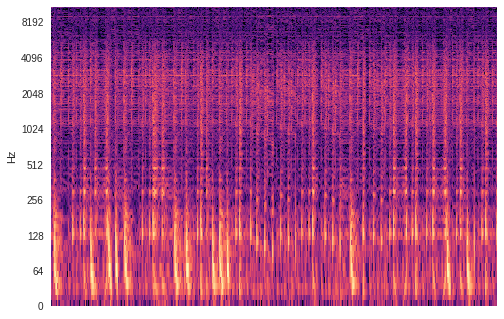

In [0]:
predicted_batch = run(encoder, decoder, start_sequences, 20)

predicted_audio_a = griffin_lim(predicted_batch[0].T, 
                                n_iter=100, 
                                window='hann', 
                                n_fft=fft_size, 
                                hop_length=hop_length)
plot_audio(predicted_audio_a) 

IPython.display.Audio(predicted_audio_a, rate=dataset.sample_rate)

/usr/local/lib/python3.6/dist-packages/librosa/util/utils.py:1725: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(x.dtype, float) or np.issubdtype(x.dtype, complex):
/usr/local/lib/python3.6/dist-packages/librosa/display.py:656: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  if np.issubdtype(data.dtype, np.complex):


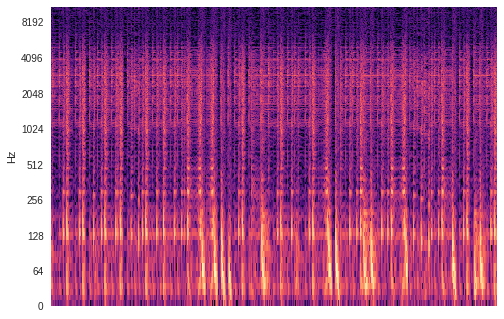

In [0]:
predicted_audio_b = griffin_lim(predicted_batch[1].T, 
                                n_iter=100, 
                                window='hann', 
                                n_fft=fft_size, 
                                hop_length=hop_length)
plot_audio(predicted_audio_b) 

IPython.display.Audio(predicted_audio_b, rate=dataset.sample_rate)

/usr/local/lib/python3.6/dist-packages/librosa/util/utils.py:1725: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(x.dtype, float) or np.issubdtype(x.dtype, complex):
/usr/local/lib/python3.6/dist-packages/librosa/display.py:656: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  if np.issubdtype(data.dtype, np.complex):


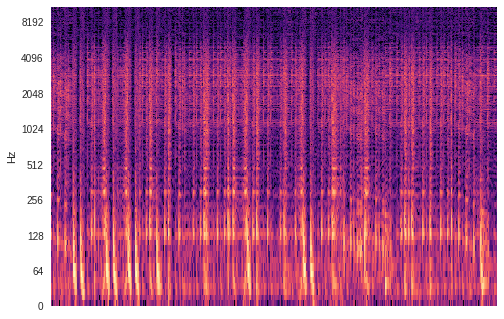

In [0]:
predicted_audio_c = griffin_lim(predicted_batch[2].T, 
                                n_iter=100, 
                                window='hann', 
                                n_fft=fft_size, 
                                hop_length=hop_length)
plot_audio(predicted_audio_c) 

IPython.display.Audio(predicted_audio_c, rate=dataset.sample_rate)

/usr/local/lib/python3.6/dist-packages/librosa/util/utils.py:1725: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(x.dtype, float) or np.issubdtype(x.dtype, complex):
/usr/local/lib/python3.6/dist-packages/librosa/display.py:656: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  if np.issubdtype(data.dtype, np.complex):


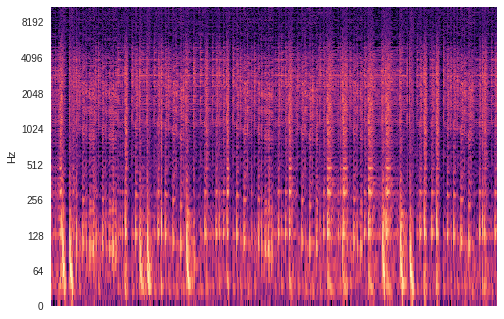

In [0]:
predicted_audio_d = griffin_lim(predicted_batch[3].T, 
                                n_iter=100, 
                                window='hann', 
                                n_fft=fft_size, 
                                hop_length=hop_length)
plot_audio(predicted_audio_d) 

IPython.display.Audio(predicted_audio_d, rate=dataset.sample_rate)